# SPX500 EDA

Exploration of recent events on the index.

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os
import seaborn as sns

load_dotenv()

api_key = os.getenv("API_KEY")

tqdm.pandas()

Load timeseries.

In [2]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries

# Initialize AlphaVantage API
ts = TimeSeries(key=api_key, output_format='pandas')

ValueError: The AlphaVantage API key must be provided either through the key parameter or through the environment variable ALPHAVANTAGE_API_KEY. Get a free key from the alphavantage website: https://www.alphavantage.co/support/#api-key

Create TS dataframes for analysis.

In [ ]:
INTERVALS = ['1min', '5min', '15min', '30min', '60min']
TICKER = 'SPY'

data = {}
for interval in tqdm(INTERVALS, "intervals"):
    file_path = f'./ts/{TICKER}-{interval}.json'
    if os.path.exists(file_path):
        # Load the existing file into a DataFrame
        df = pd.read_json(file_path)
        data[interval] = df
    else:
        df, _ = ts.get_intraday(
            symbol='SPY', interval=interval, outputsize='full')
        df.rename(columns={'4. close': 'p', '5. volume': 'v'}, inplace=True)
        data[interval] = df[['p', 'v']]

        # Cache it
        data[interval].to_json(file_path, date_format='iso')

intervals:   0%|          | 0/5 [00:00<?, ?it/s]

Normalize TS into deltas.

In [ ]:
# Calculate the percentage change for each interval
normalized_data = {}
for interval, df in data.items():
    normalized_data[interval] = df.pct_change().dropna()

price_changes_df = pd.DataFrame(columns=INTERVALS)
volume_changes_df = pd.DataFrame(columns=INTERVALS)
# Loop through each interval and combine the price and volume changes
for interval, df in normalized_data.items():
    price_changes_dfs = df['p']
    volume_changes_dfs = df['v']

    price_changes_df[interval] = price_changes_dfs
    volume_changes_df[interval] = volume_changes_dfs

# Print the combined dataframe
price_changes_df = price_changes_df.fillna(0.)
print(price_changes_df.head(3))

volume_changes_df = volume_changes_df.fillna(0.)
print(volume_changes_df.head(3))

                         1min  5min  15min  30min  60min
2023-08-08 19:59:00 -0.000256   0.0    0.0    0.0    0.0
2023-08-08 19:58:00 -0.000033   0.0    0.0    0.0    0.0
2023-08-08 19:57:00  0.000022   0.0    0.0    0.0    0.0
                         1min  5min  15min  30min  60min
2023-08-08 19:59:00 -0.994722   0.0    0.0    0.0    0.0
2023-08-08 19:58:00 -0.649947   0.0    0.0    0.0    0.0
2023-08-08 19:57:00 -0.993967   0.0    0.0    0.0    0.0


Add lags for autocorellations.

In [ ]:
# Define lag values for auto-correlation
lags = [1, 2, 5, 10, 20, 40, 100]

# Calculate auto-correlation for each interval and lag
auto_correlations = {}
for interval, df in normalized_data.items():
    acf_vals = [df['p'].autocorr(lag=lag) for lag in lags]
    auto_correlations[interval] = acf_vals

auto_correlations["1min"]

[-0.4217560423839985,
 -0.005308449157076933,
 -0.0031105849981826537,
 0.00157455480648129,
 -0.0002207278517895523,
 0.004561766276183533,
 1.0322519716956044e-05]

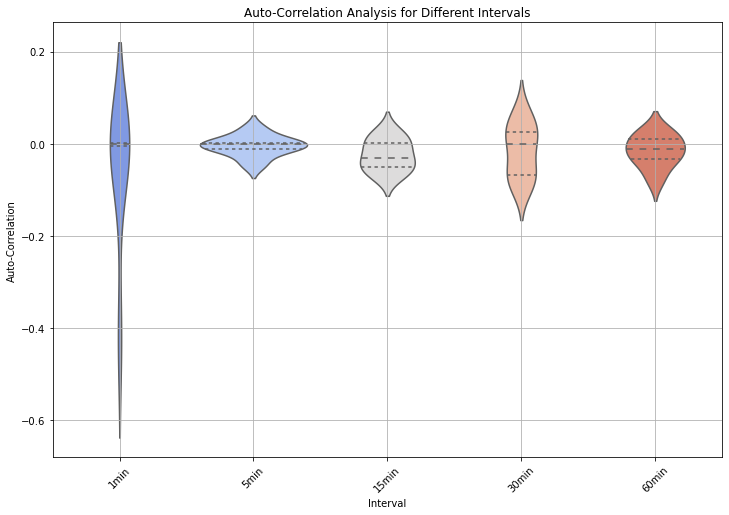

In [ ]:
# Create a DataFrame from the auto-correlation values
auto_corr_df = pd.DataFrame(auto_correlations, index=lags)

# Create a violin plot to visualize auto-correlation values
plt.figure(figsize=(12, 8))
sns.violinplot(data=auto_corr_df, inner="quartile", palette="coolwarm")
plt.xlabel('Interval')
plt.ylabel('Auto-Correlation')
plt.title('Auto-Correlation Analysis for Different Intervals')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Is there a pattern between Volume and Price?

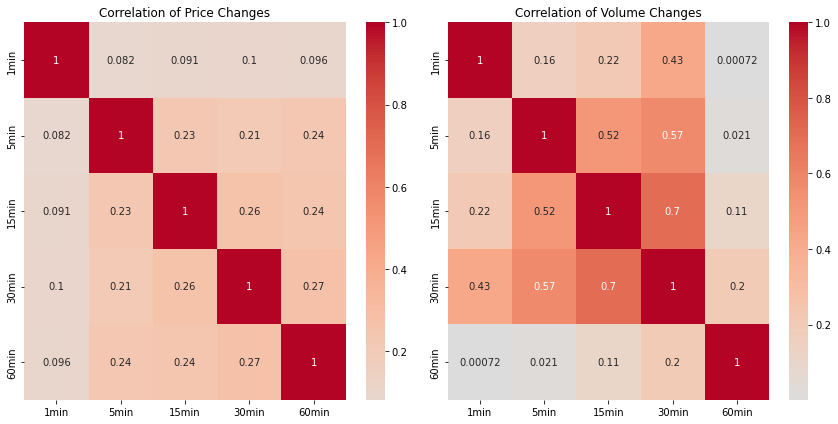

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the heatmap for price changes correlation
sns.heatmap(price_changes_df.corr(), annot=True,
            cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Correlation of Price Changes')

# Plot the heatmap for volume changes correlation
sns.heatmap(volume_changes_df.corr(), annot=True,
            cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Correlation of Volume Changes')

plt.tight_layout()
plt.show()

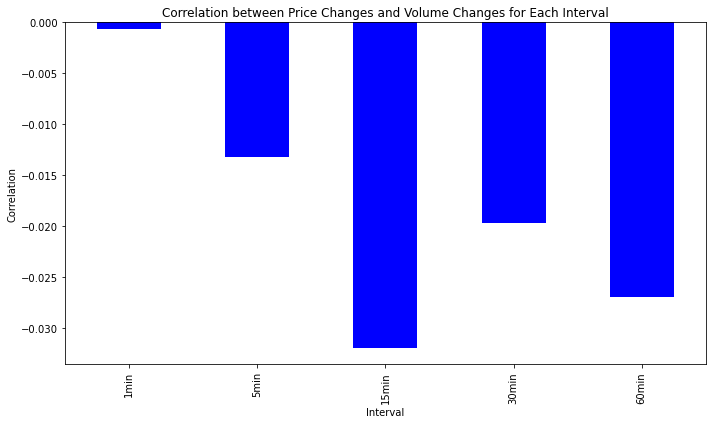

In [ ]:
# Calculate the correlation matrix between price changes and volume changes for each interval
correlation_matrix = price_changes_df.corrwith(volume_changes_df)

# Create a bar plot to visualize the correlations
plt.figure(figsize=(10, 6))

correlation_matrix.plot(kind='bar', color='blue')
plt.title('Correlation between Price Changes and Volume Changes for Each Interval')
plt.xlabel('Interval')
plt.ylabel('Correlation')

plt.tight_layout()
plt.show()

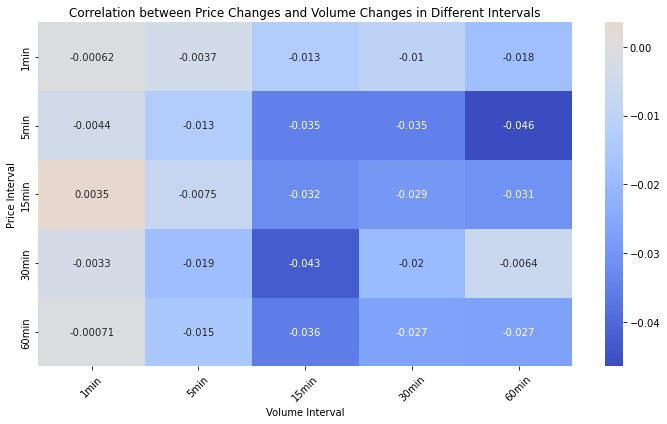

In [ ]:
# Create a new DataFrame for correlation analysis between different intervals
correlation_intervals = pd.DataFrame()

# Loop through each interval and calculate the correlation with other intervals
for price_interval in price_changes_df.columns:
    for volume_interval in volume_changes_df.columns:
        correlation = price_changes_df[price_interval].corr(
            volume_changes_df[volume_interval])
        correlation_intervals.loc[price_interval,
                                  volume_interval] = correlation

# Create a heatmap to visualize the correlations between price changes and volume changes in different intervals
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_intervals, annot=True, cmap='coolwarm', center=0)
plt.title(
    'Correlation between Price Changes and Volume Changes in Different Intervals')
plt.xlabel('Volume Interval')
plt.ylabel('Price Interval')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

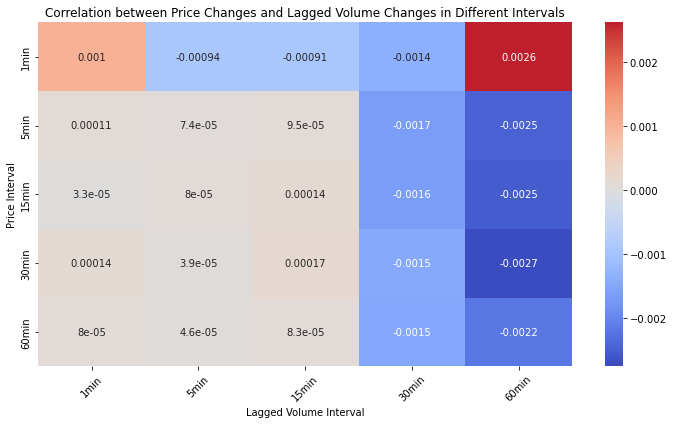

In [ ]:
# Create a new DataFrame for correlation analysis between price changes and lagged volume changes in different intervals
correlation_intervals = pd.DataFrame()

# Loop through each interval and calculate the correlation with lagged volume changes in other intervals
for price_interval in price_changes_df.columns:
    for lagged_volume_interval in volume_changes_df.columns:
        lagged_volume_changes = volume_changes_df[lagged_volume_interval].shift(
            1)  # Lag volume changes
        correlation = price_changes_df[price_interval].corr(
            lagged_volume_changes)
        correlation_intervals.loc[price_interval,
                                  lagged_volume_interval] = correlation

# Create a heatmap to visualize the correlations between price changes and lagged volume changes in different intervals
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_intervals, annot=True, cmap='coolwarm', center=0)
plt.title(
    'Correlation between Price Changes and Lagged Volume Changes in Different Intervals')
plt.xlabel('Lagged Volume Interval')
plt.ylabel('Price Interval')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()